## Driving in a human like way

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Basic configuration
warnings.filterwarnings("ignore")  # Ignore warnings

# Aesthetics
sns.set(context="notebook", font_scale=1.14, style="ticks",
        rc={"figure.figsize": (10, 5),
            "figure.facecolor": "none",
            "axes.facecolor": "none"})
plt.rcParams["lines.markersize"] = 13

# Metrics
METRICS_HUMAN_LIKE = ['act_acc', 'accel_val_mae', 'steer_val_mae', 'speed_mae', 'ADE']
METRICS_PERFORMANCE = ['goal_rate', 'off_road', 'collision_rate']

### Helper functions

In [91]:
def mean_plus_binary_se(ser: pd.Series, scale: float = 100, n:int = 200) -> str:
    """Compute the mean and standard error for binary outcomes."""
    p_metric = ser.mean()
    se_binary = np.sqrt(p_metric * (1 - p_metric) / n)
    return f"{p_metric*scale:.2f} ± {se_binary*scale:.2f}"        
        
def mean_plus_se(ser: pd.Series) -> str:
    """Compute the mean and standard error for binary outcomes."""
    return f"{ser.mean():.2f} ± {ser.sem():.2f}"        
                

def make_figure(df_agg, hl_metric, fig_name, x_label, palette='tab10'):
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
    
    # Draw lines
    sns.lineplot(
        data=df_agg,
        x=hl_metric,
        y='goal_rate',
        palette=palette,
        ax=axes[0],
        c='lightgrey',
        zorder=1,
    )
    
     # Draw lines
    sns.lineplot(
        data=df_agg,
        x=hl_metric,
        y='off_road',
        palette=palette,
        ax=axes[1],
        c='lightgrey',
        zorder=1,
    )
    
    # Draw lines
    sns.lineplot(
        data=df_agg,
        x=hl_metric,
        y='collision_rate',
        palette=palette,
        ax=axes[2],
        c='lightgrey',
        zorder=1,
    )


    # Goal rate
    sns.scatterplot(
        data=df_agg,
        x=hl_metric,
        y='goal_rate',
        style='Reg. weight',
        hue='Reg. weight',
        legend=False,
        palette=palette,
        ax=axes[0]
    )

    sns.scatterplot(
        data=df_agg,
        x=hl_metric,
        y='off_road',
        style='Reg. weight',
        hue='Reg. weight',
        legend=False,
        palette=palette,
        ax=axes[1],
    )
    
    sns.scatterplot(
        data=df_agg,
        x=hl_metric,
        y='collision_rate',
        style='Reg. weight',
        hue='Reg. weight',
        legend=True,
        palette=palette,
        ax=axes[2]
    )


    axes[0].grid(True, alpha=.3)
    axes[1].grid(True, alpha=.3)
    axes[2].grid(True, alpha=.3)
    axes[2].legend(
        bbox_to_anchor=(1.05, 1.0), 
        loc="upper left", 
        fontsize=11, 
        labelspacing=0.5
    )

    axes[0].set_ylabel("Goal rate [%]")
    axes[1].set_ylabel("Off-road [%]")
    axes[2].set_ylabel("Collision rate [%]")

    axes[0].set_xlabel(f"{x_label}")
    axes[1].set_xlabel(f"{x_label}")
    axes[2].set_xlabel(f"{x_label}")
    plt.tight_layout()
    
    plt.savefig(f"../evaluation/figures/{fig_name}.pdf", bbox_inches='tight')
    

def plot_agent_trajectory(agent_df, title, fig_name):
    """Make figure of agent position, speed and action trajectories."""

    # Get accuracy for fig
    nonnan_ids = np.logical_not(
        np.logical_or(
            np.isnan(agent_df.policy_act),
            np.isnan(agent_df.expert_act),
        ),
    )
    fig, axs = plt.subplots(1, 1, figsize=(4, 4))

    fig.suptitle(f'Vehicle trajectory | {title}', fontsize=14)
    
    # Plot expert and agent positions
    axs.plot(agent_df.expert_pos_x, agent_df.expert_pos_y, '.-', color='g', label='Expert')
    axs.plot(agent_df.policy_pos_x, agent_df.policy_pos_y, '.-', color='tab:orange', label='Policy')
    axs.scatter(agent_df.expert_pos_x.iloc[0], agent_df.expert_pos_y.iloc[0], marker='x', color='b', s=120, zorder=5, label=r'$(x_0, y_0)$')
    axs.scatter(agent_df.goal_pos_x.iloc[0], agent_df.goal_pos_y.iloc[0], marker='d', color='darkgreen', s=110, zorder=5, label='goal')
    
    axs.legend(facecolor='white', framealpha=1)
    axs.grid(True, alpha=0.5)  
    axs.set_xlabel(r'$x$')
    axs.set_ylabel(r'$y$')
    
    plt.savefig(f"../evaluation/figures/{fig_name}.pdf", bbox_inches='tight')

### Load trade-off results df

In [84]:
# Self-play df
#df_res = pd.read_csv("../evaluation/results/df_trade_off_on_200_scenes_self_play.csv")

# Log-replay df
df_res = pd.read_csv("../evaluation/results/df_trade_off_on_200_scenes_log_replay.csv")

In [85]:
mapping = {
    np.nan: "BC",
    0.0: "PPO",
    0.005: "HR-PPO | λ = 0.005",
    0.01: "HR-PPO | λ = 0.01",
    0.02: "HR-PPO | λ = 0.02",
    0.025: "HR-PPO | λ = 0.025",
    0.05: "HR-PPO | λ = 0.05",
    0.06: "HR-PPO | λ = 0.06",
    0.07: "HR-PPO | λ = 0.09",
    0.08: "HR-PPO | λ = 0.08",
    0.5: "HR-PPO | λ = 0.5",
    0.2: "HR-PPO | λ = 0.2",
    0.1: "HR-PPO | λ = 0.1",
}

df_res["Reg. weight"] = df_res["Reg. weight"].replace(mapping)
df_res.dropna(subset=['ADE'], inplace=True) # Drop invalid values

In [86]:
# Create aggregate table
df_agg = df_res.groupby(['Reg. weight'])[METRICS_PERFORMANCE+METRICS_HUMAN_LIKE+METRICS_PERFORMANCE].mean() 
df_agg["goal_rate"] = df_agg["goal_rate"] * 100
df_agg["off_road"] = df_agg["off_road"] * 100
df_agg["collision_rate"] = df_agg["collision_rate"] * 100
df_agg["act_acc"] = df_agg["act_acc"] * 100

### Make log-replay table

In [92]:
df_tab = df_res[df_res['Reg. weight'].isin(['BC', 'PPO', 'HR-PPO | λ = 0.06'])]
df_tab = df_tab.pivot_table(
    index=['Reg. weight'],
    values=METRICS_PERFORMANCE,
    aggfunc=mean_plus_binary_se, 
)

display(df_tab)

,collision_rate,goal_rate,off_road
Reg. weight,,,
BC,6.00 ± 1.68,69.50 ± 3.26,11.00 ± 2.21
HR-PPO | λ = 0.06,8.50 ± 1.97,90.00 ± 2.12,1.50 ± 0.86
PPO,28.00 ± 3.17,71.50 ± 3.19,2.00 ± 0.99


In [93]:
df_tab = df_res[df_res['Reg. weight'].isin(['BC', 'PPO', 'HR-PPO | λ = 0.06'])]
df_tab = df_tab.pivot_table(
    index=['Reg. weight'],
    values=METRICS_HUMAN_LIKE,
    aggfunc=mean_plus_se, 
)

display(df_tab)

,ADE,accel_val_mae,act_acc,speed_mae,steer_val_mae
Reg. weight,,,,,
BC,0.08 ± 0.01,0.41 ± 0.02,0.22 ± 0.01,0.09 ± 0.01,0.01 ± 0.00
HR-PPO | λ = 0.06,0.56 ± 0.03,1.15 ± 0.06,0.10 ± 0.01,1.83 ± 0.08,0.01 ± 0.00
PPO,1.22 ± 0.06,3.92 ± 0.05,0.00 ± 0.00,4.77 ± 0.19,0.09 ± 0.00


### Figures

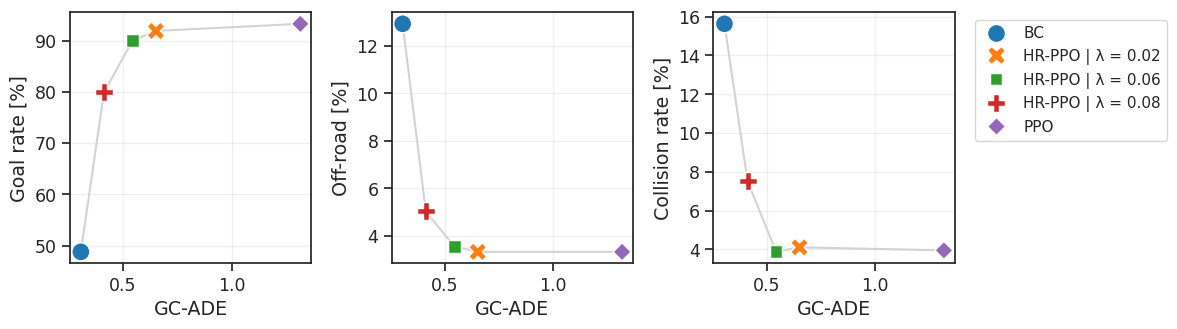

In [37]:
make_figure(df_agg=df_agg, hl_metric='ADE', x_label='GC-ADE', fig_name='gc_ade_x_effectiveness')

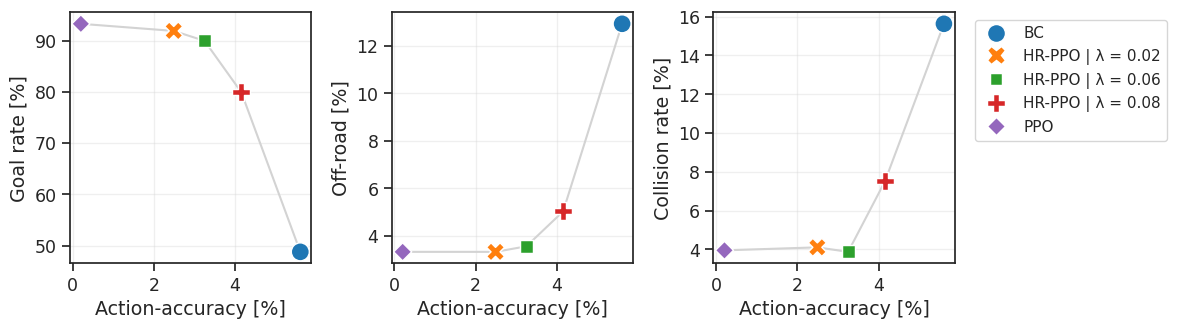

In [38]:
make_figure(df_agg=df_agg, hl_metric='act_acc', x_label='Action-accuracy [%]', fig_name='acc_x_effectiveness')

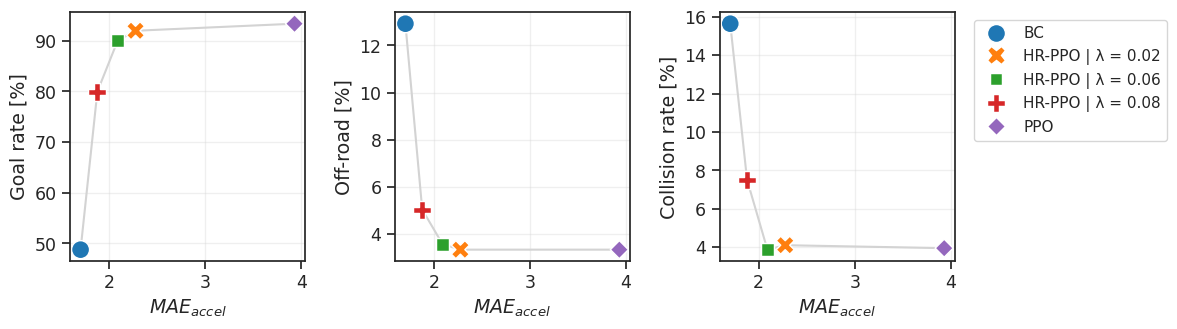

In [39]:
make_figure(df_agg=df_agg, hl_metric='accel_val_mae', x_label=r'$MAE_{accel}$', fig_name='mae_accel_x_effectiveness')

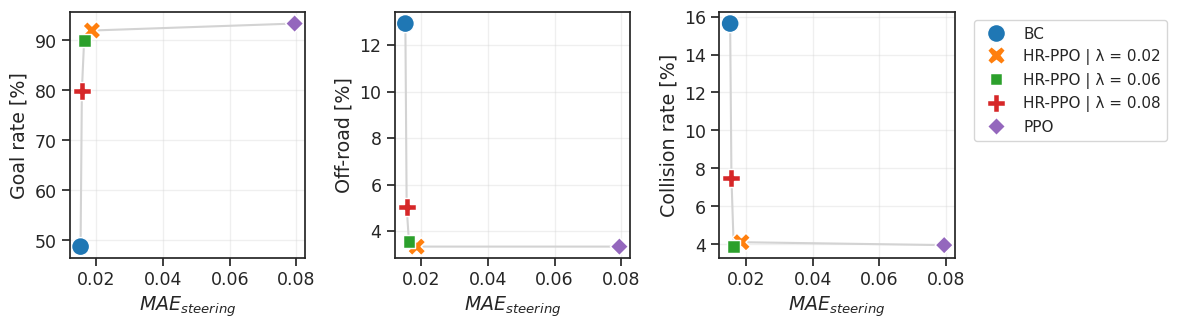

In [40]:
make_figure(df_agg=df_agg, hl_metric='steer_val_mae', x_label=r'$MAE_{steering}$', fig_name='mae_steer_x_effectiveness')

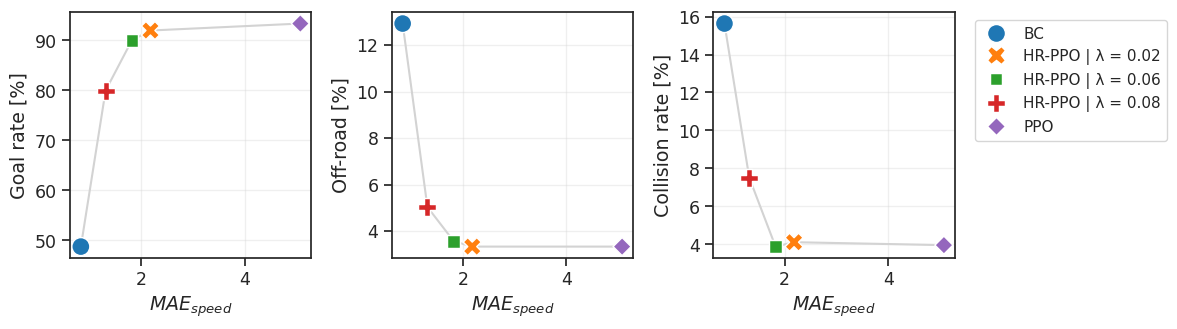

In [41]:
make_figure(df_agg=df_agg, hl_metric='speed_mae', x_label=r'$MAE_{speed}$', fig_name='acc_x_mae_speed')